In [3]:
import sys
sys.path.append("..")

import dataInterpreter as dt
import enrichmentAnalysis as ea
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score

In [10]:
data = dt.get_data('A549', 'healthy_ace2', 'sars-cov2_ace2')
columns_healthy = dt.get_columns('A549', 'healthy_ace2')
columns_sars_cov2 = dt.get_columns('A549', 'sars-cov2_ace2')

filtered_data = dt.get_p_values('mannwhitneyu', data, columns_healthy, columns_sars_cov2, limit = 0.01)
filtered_data

,Series6_A549-ACE2_Mock_1,Series6_A549-ACE2_Mock_2,Series6_A549-ACE2_Mock_3,Series16_A549-ACE2_Mock_1,Series16_A549-ACE2_Mock_2,Series16_A549-ACE2_Mock_3,Series6_A549-ACE2_SARS-CoV-2_1,Series6_A549-ACE2_SARS-CoV-2_2,Series6_A549-ACE2_SARS-CoV-2_3,Series16_A549-ACE2_SARS-CoV-2_1,Series16_A549-ACE2_SARS-CoV-2_2,Series16_A549-ACE2_SARS-CoV-2_3,p-value
NOC2L,7.636752,5.257495,7.356918,5.075174,6.688355,6.385194,5.910797,4.744932,4.442651,4.672829,4.595120,4.644391,0.006533
MRPL20,7.234177,4.762174,6.806829,4.890349,6.424869,6.238325,5.598422,4.110874,4.127134,4.584967,4.624973,4.488636,0.006533
ATAD3A,6.306275,3.951244,5.902633,3.610918,5.393628,5.036953,4.644391,3.401197,3.295837,3.218876,3.610918,3.135494,0.008061
TMEM52,1.098612,0.693147,2.484907,1.386294,1.945910,1.945910,0.693147,0.000000,0.693147,0.693147,0.000000,0.693147,0.004893
FAM213B,5.225747,2.944439,4.955827,3.637586,4.897840,4.624973,3.135494,2.079442,2.564949,2.708050,2.079442,3.044522,0.006453
...,...,...,...,...,...,...,...,...,...,...,...,...,...
FLNA,11.316886,8.998631,10.952384,8.698848,10.348590,10.068409,9.293854,8.181720,7.784889,8.258940,8.276395,8.195885,0.006533
ATP6AP1,8.226841,5.843544,7.920810,5.924256,7.528332,7.390799,6.180017,5.081404,4.820282,5.278115,5.370638,5.147494,0.006533
LAGE3,5.817111,3.713572,5.605802,3.663562,5.303305,5.170484,4.127134,3.465736,2.995732,2.484907,3.218876,3.295837,0.006533
G6PD,9.982945,7.779467,9.778321,7.808323,9.339085,9.110851,7.747597,6.594413,6.269096,6.267201,6.137727,5.899897,0.002537


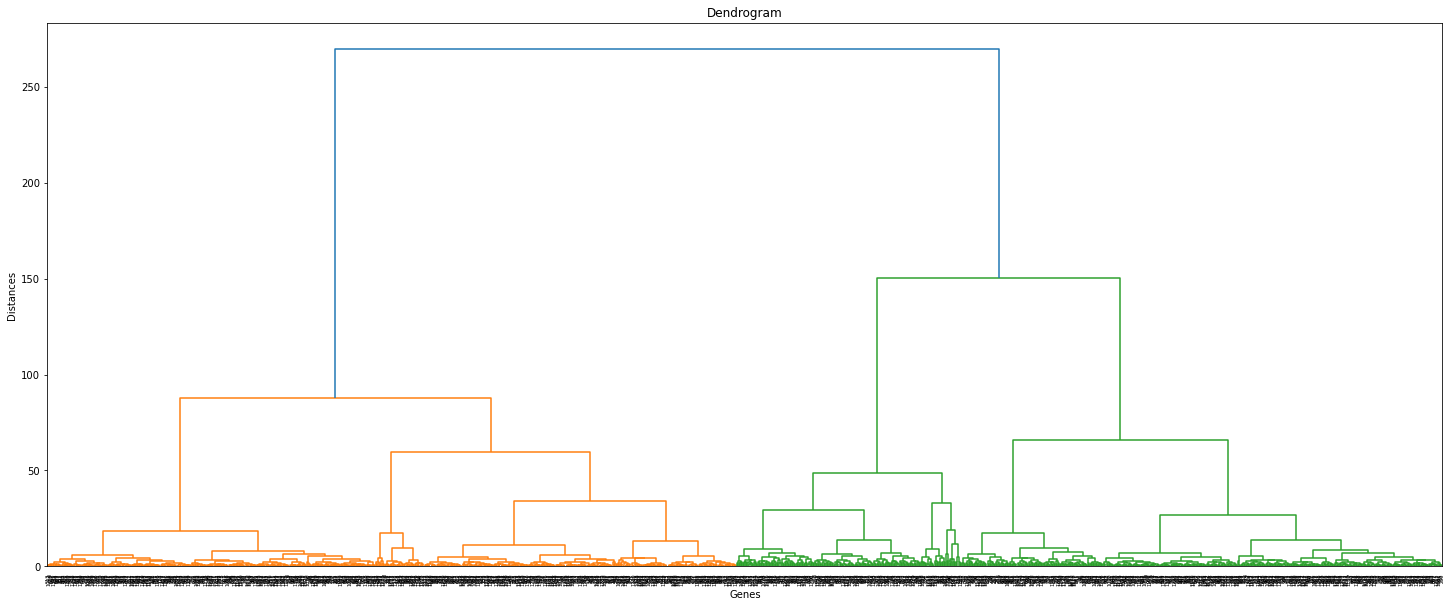

In [11]:
filtered_data.drop(['p-value'], axis = 1, inplace = True)
fig = dt.plot_dendrogram(filtered_data)

In [12]:
fig.savefig('test_dendro2.pdf', format='pdf')

In [14]:
labels = {}

models = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
labels['distance'] = models.fit_predict(filtered_data)

In [15]:
labels['distance']

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [16]:
dissimilarity = 1 - np.abs(filtered_data.T.corr())
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['pearson'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [17]:
labels['pearson']

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [18]:
dissimilarity = 1 - np.abs(filtered_data.T.corr(method='spearman'))
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['spearman'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [19]:
labels['spearman']

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [20]:
from itertools import groupby

clusters = {}

for key1, label1 in labels.items():
    clusters[key1] = [list(map(lambda x: x[0], v)) for k,v in groupby(sorted(zip(filtered_data.index, labels['spearman']), key = lambda x: x[1]), lambda s: s[1])]
    
    for key2, label2 in labels.items():
        if key1 != key2:
            print(key1, ' vs ', key2, ': ', adjusted_rand_score(label1, label2))

distance  vs  pearson :  0.09669341407467442
distance  vs  spearman :  0.2164052293133387
pearson  vs  distance :  0.09669341407467442
pearson  vs  spearman :  0.2454257048421495
spearman  vs  distance :  0.2164052293133387
spearman  vs  pearson :  0.2454257048421495


In [ ]:
i = 0
for c in clusters['distance']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [34]:
import enrichmentAnalysis as ea

results_enrichment = {'distance': [], 'pearson': [], 'spearman': []}

for cluster_type in clusters:
    for cluster in clusters[cluster_type]:
        results_enrichment[cluster_type] += [ea.getEnrichment(list(cluster), 'GO_Biological_Process_2021')['GO_Biological_Process_2021']]

results_enrichment

Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlap

{'distance': [[[1,
    'positive regulation of heat generation (GO:0031652)',
    3.318355775015145e-05,
    380.1904761904762,
    3921.0777680384267,
    ['PTGER3', 'TNF'],
    0.008317679950879538,
    0,
    0],
   [2,
    'regulation of fever generation (GO:0031620)',
    3.318355775015145e-05,
    380.1904761904762,
    3921.0777680384267,
    ['PTGER3', 'TNF'],
    0.008317679950879538,
    0,
    0],
   [3,
    'positive regulation of fever generation (GO:0031622)',
    4.9717470517636224e-05,
    285.12857142857143,
    2825.38297174799,
    ['PTGER3', 'TNF'],
    0.008317679950879538,
    0,
    0],
   [4,
    'inflammatory response (GO:0006954)',
    6.217319465675675e-05,
    13.706944444444444,
    132.75979750902968,
    ['PTGER3', 'CDO1', 'SELE', 'CXCL2', 'TNF'],
    0.008317679950879538,
    0,
    0],
   [5,
    'regulation of vascular wound healing (GO:0061043)',
    9.259012932333438e-05,
    190.06666666666666,
    1765.2114783882112,
    ['FOXC2', 'TNF'],
    0.008

In [35]:
import json

with open('results_A549-ACE.json', 'w') as file:
     file.write(json.dumps(results_enrichment)) # use `json.loads` to do the reverse

In [4]:
import json

with open('results_A549-ACE.json') as file:
    results_enrichment = json.load(file)

In [5]:
dataset = {'p-value': [], 'Score': [], 'Cluster': []}
index = []

for cluster_num in range(len(results_enrichment['distance'])):
    for term in results_enrichment['distance'][cluster_num]:
        index += [term[1]]
        dataset['p-value'] += [term[6]]
        dataset['Score'] += [term[4]]
        dataset['Cluster'] += [cluster_num]
enrichment_dataset = pd.DataFrame(dataset, index = index)

In [10]:
pd.set_option("display.max_rows", None)
selection = enrichment_dataset[enrichment_dataset['p-value'] < 0.01].sort_values('Score', ascending = False).head(25)

selection['p-value'] = selection['p-value'].map(lambda x: '%.2E' % x)
selection['Score'] = selection['Score'].map(lambda x: '%.2f' % x)

selection.to_csv('A549-ACE2_table.csv')
selection

,p-value,Score,Cluster
positive regulation of heat generation (GO:0031652),8.32E-03,3921.08,0
regulation of fever generation (GO:0031620),8.32E-03,3921.08,0
positive regulation of fever generation (GO:0031622),8.32E-03,2825.38,0
regulation of vascular wound healing (GO:0061043),8.32E-03,1765.21,0
positive regulation of steroid biosynthetic process (GO:0010893),8.32E-03,1765.21,0
aerobic electron transport chain (GO:0019646),3.06E-20,833.55,2
mitochondrial ATP synthesis coupled electron transport (GO:0042775),3.06E-20,801.88,2
"mitochondrial electron transport, NADH to ubiquinone (GO:0006120)",2.72E-13,692.38,2
L-phenylalanine catabolic process (GO:0006559),4.28E-03,637.69,2
erythrose 4-phosphate/phosphoenolpyruvate family amino acid catabolic process (GO:1902222),4.28E-03,637.69,2


In [ ]:
i = 0
for c in clusters['pearson']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['spearman']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

## Clustering on columns

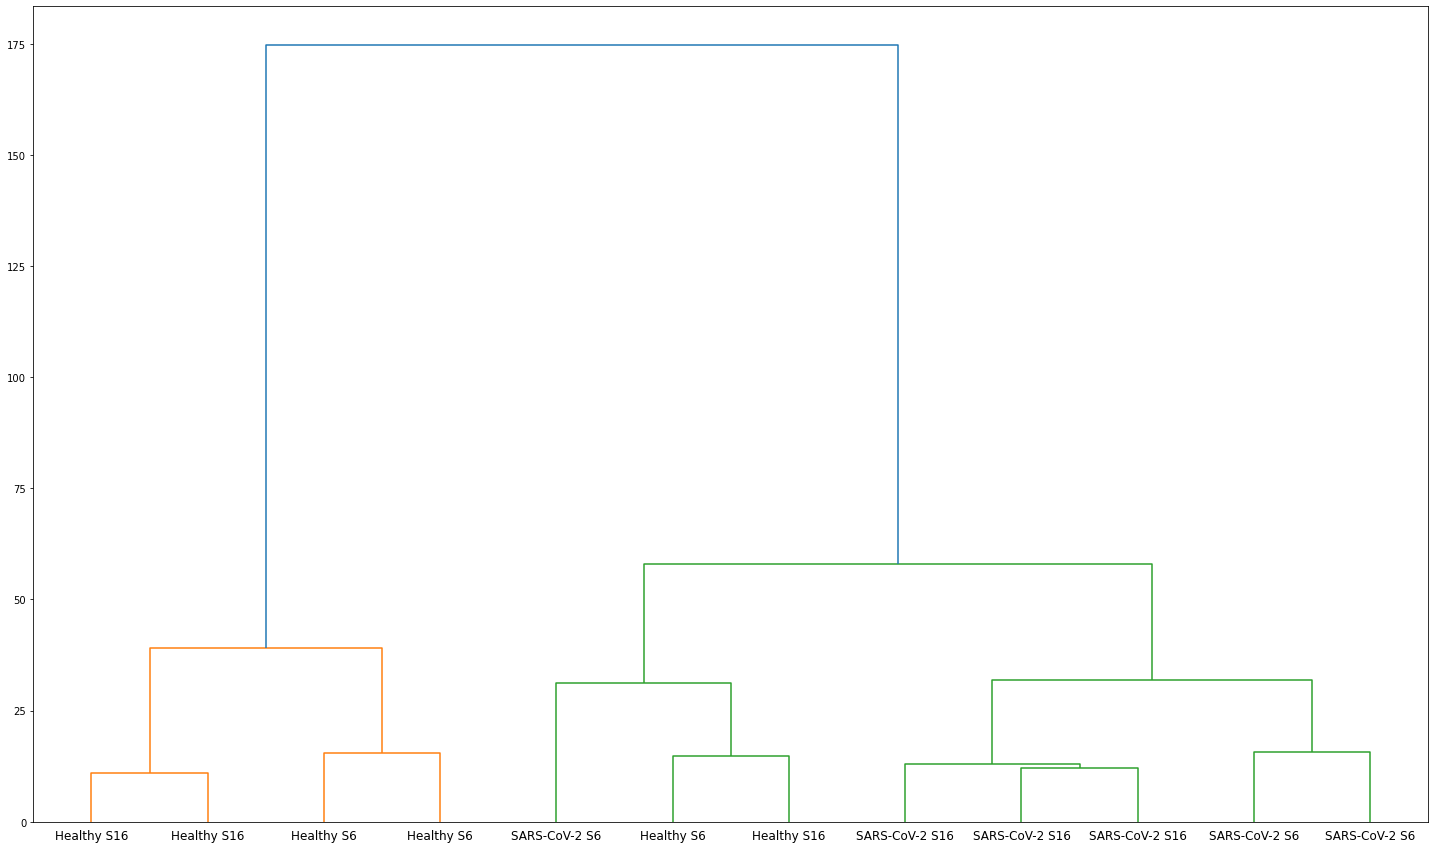

In [48]:
fig = plt.figure(figsize=(25, 15))
dendrogram = sch.dendrogram(sch.linkage(filtered_data.T, method="ward"), labels = list(['Healthy S6', 'Healthy S6', 'Healthy S6', 'Healthy S16', 'Healthy S16', 'Healthy S16', 'SARS-CoV-2 S6', 'SARS-CoV-2 S6', 'SARS-CoV-2 S6', 'SARS-CoV-2 S16', 'SARS-CoV-2 S16', 'SARS-CoV-2 S16']))
plt.show()

In [18]:
labels_columns = {}

models = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
labels_columns['distance'] = models.fit_predict(filtered_data.T)

labels_true = [0 if col in columns_healthy else 1 for col in filtered_data.columns]

print("True: ", labels_true)
print("Predicted: ", labels_columns['distance'])
print(adjusted_rand_score(labels_true, labels_columns['distance']))

True:  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [1 0 1 0 1 1 0 0 0 0 0 0]
0.39560439560439553
